In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
from importlib import reload
import cv2
import json
from pathlib import Path

print('Python | Pytorch | OpenCV versions: %s | %s | %s' %(sys.version, torch.__version__, cv2.__version__))

sys.path.append('/home/blanca/mnt/projects/')
import tools
from tools.utils import *
from tools.visuals import *

if __name__ == "__main__":
    print("lol")

Python | Pytorch | OpenCV versions: 3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0] | 0.4.1 | 3.4.3
lol


In [4]:
xml_annotations_paths = [
                '__toy_plane/AnnotationsDV'
]
ann_files = []
for xml_annotations_path in xml_annotations_paths:
    path = Path(xml_annotations_path)
    ann_files.append(np.array(list(path.glob("*"))))

ann_files = np.concatenate(ann_files, axis=0)
len(ann_files)

741

#### object_selection: body + drill

In [200]:
# cat_file_41 = path.parent / Path('toy_plane_attbs_41.names') # 41 classes
# cat_file_12 = path.parent / Path('toy_plane_attbs_body_drill.names') # 11 classes
# with open(str(cat_file_41), 'r') as f:
#     cat_data_41 = [i.strip() for i in f.readlines()]
# with open(str(cat_file_12), 'r') as f:
#     cat_data_12 = [i.strip() for i in f.readlines()]

# cat_dic_41 = {i:cat_data_41[i] for i in range(len(cat_data_41))}
# cat_dic_12 = {i:cat_data_12[i] for i in range(len(cat_data_12))}

In [6]:
path = path
cat_file = path.parent / Path('toy_plane_attbs_body_drill.names') # 11 classes

with open(str(cat_file), 'r') as f:
    cat_data = [i.strip() for i in f.readlines()]

cat_data = [i.lower() for i in cat_data]
cat_dic = {i:cat_data[i] for i in range(len(cat_data))}
cat_data

['body',
 'drill',
 'has wing 1',
 'has wing 2',
 'has small wheels',
 'has propeller',
 'has cockpit',
 'has carriage',
 'has drill tip',
 'has hex drill tip',
 'button pressed']

In [7]:
class_names = [
    'Body', 
    'Drill'
]
attbs_names = [
    'Has wing 1', 
    'Has wing 2', 
    'Has small wheels', 
    'Has propeller', 
    'Has cockpit', 
    'Has carriage',
    'Has drill tip', 
    'Has hex drill tip',
    'Button pressed', 
]

class_names = [i.lower() for i in class_names]
attbs_names = [i.lower() for i in attbs_names]

In [8]:
import os, sys
import xmltodict
from pathlib import Path
import numpy as np
from skimage import io
import operator
from functools import reduce
import collections

def xy_xy2ulxy_wh(x):  # Convert bounding box format from [x1, y1, x2, y2] to [x, y, w, h]
    y = np.zeros(len(x))
    y[0] = x[0]
    y[1] = x[1]
    y[2] = x[2] - x[0]
    y[3] = x[3] - x[1]
    return y.tolist()

def xy_xy2bbxy_wh(x):  # Convert bounding box format from [x1, y1, x2, y2] to [x, y, w, h]
    y = np.zeros(len(x))
    y[0] = (x[0] + x[2]) / 2
    y[1] = (x[1] + x[3]) / 2
    y[2] = x[2] - x[0]
    y[3] = x[3] - x[1]
    return y.tolist()
     
def adjust_polygon_format(o_polygon):
    polygon_list = []
    co_k_x = [i for i in list(o_polygon.keys()) if i[0] == 'x']
    co_k_x = sorted(co_k_x, key=lambda x: int(x[1:]))
    for i in co_k_x:
        ix = i[1:]
        xk, yk = i, 'y' + ix
        polygon_list.append([float(o_polygon[xk]), float(o_polygon[yk])])
        
    polygon_list = reduce(operator.add, polygon_list)
    
    return polygon_list

## convert fumehood dv

In [26]:
def create_mcnn_dataset(ann_files, cat_file, att_file=None):

    with open(str(cat_file), 'r') as f:
        cat_data = [i.strip() for i in f.readlines()]
        cat_data = [i.lower() for i in cat_data]

    cat_dic = {i:cat_data[i] for i in range(len(cat_data))}

    ### CATEGORIES ###

    categories = [{
        "id" : i, #int, 
        "name" : j, #str, 
        "supercategory" : j, #str,
    } for i, j in cat_dic.items()]

    ### DATASET ###

    info = {
        "year" : '2018', 
        "version" : '1', 
        "description" : 'fumehood', 
        "contributor" : 'v7', 
        "url" : 'none', 
        "date_created" : '2018/09/20',
    }

    dataset = {

        "info" : info, 
        "images" : [],       # image
        "annotations" : [],  # annotation
        "licenses" : [],     # license
        "categories": categories
    }

    count_i = 0
    count_o = 0
    total_dv_files = 0
    
    obss_wo_atts = 0
    obss_w1_atts = 0
    obss_ws_atts = 0
    
    count_not_anno = 0

    for file in ann_files:
        with open(str(file)) as fd:
            try: doc = xmltodict.parse(fd.read())
            except: print(file); continue
            count_i += 1
            # creating an image: 
            data = doc['annotation']
            # image
            folder = data['folder']
            filename = data['filename']        
            session_type = folder.split('/')[-2]
            session = folder.split('/')[-1]
            im_name = '{:06d}'.format(int(filename.split('.png')[0]))
            im_name = '%s_%s_%s.png' %(session_type, session, im_name)
            
            url = folder + '/' + filename
            
            try:
                width = int(data['size']['width'])
                height = int(data['size']['height'])
            except: print('HERE 1'); continue
            try:
                objects = data['object']
            except: print('HERE 2', file); count_not_anno +=1; continue

            image_dic = {
                "id" : count_i, #int, 
                "width" : width, #int, 
                "height" : height, #int, 
                "file_name" : im_name, #str, 
                "license" : 0, #int, 
                "flickr_url" : 'no-flickr_url', #str, 
                "coco_url" : url, #str, 
                "date_captured" : "2018-20-01 00:00:00", #datetime,
            }

            license = {
                "id" : count_i, #int, 
                "name" : im_name, #str, 
                "url" : 'url', #str,
            }

            dataset['images'].append(image_dic)
            dataset['licenses'].append(image_dic)

            # parsing objects annotations
            if isinstance(objects, dict): objects = [objects]
        
            for i in objects:
                count_o += 1

                o_cat_name = i['name'].lower()
                if o_cat_name not in class_names: 
                    continue
                o_cat_ix = cat_data.index(o_cat_name)
                o_polygon = [[]]
#                 o_polygon = i['polygon']
#                 o_polygon = [adjust_polygon_format(o_polygon)]
                o_bbox = [i['bndbox']['xmin'], i['bndbox']['ymin'], i['bndbox']['xmax'], i['bndbox']['ymax']]
                o_bbox = xy_xy2ulxy_wh([int(i) for i in o_bbox])
                try: o_dv_angle = i['direction']['angle']; total_dv_files += 1
                except: o_dv_angle = None 
                
                attbs = [o_cat_ix]
                for i, j in i['attributes'].items(): # i(attribute), j(list of Odicts or Odict)
                    if isinstance(j, collections.OrderedDict): j = [j]
                    for ODict in j: 
#                         if ODict['#text'] == 'true' and ODict['@name'] in ['Has wing 1', 'Has wing 2', 'Has small wheels', 'Has propeller', 'Has cockpit']:
#                             cont_body += 1
#                             imgs_body.append(count_i) 
                        attb_name = ODict['@name'].lower()
                        if ODict['#text'] == 'true' and attb_name in attbs_names: 
                            attbs.append(cat_data.index(attb_name))
                        
                if len(attbs) == 1: obss_wo_atts += 1
                elif len(attbs) == 2: obss_w1_atts += 1
                elif len(attbs) > 2: obss_ws_atts += 1
                    
                annotation = {
                    "id" : count_o, #int, 
                    "image_id" : count_i, #int, 
                    "category_id" : attbs, # o_cat_ix, # attbs, #int, # list of ints
                    "segmentation" : o_polygon, # polygon format or list 
                    "area" : 33., #float, 
                    "bbox" : o_bbox, #[x, y, width, height], 
                    "iscrowd" : 0, # 0 or 1,
                    "angle" : float(o_dv_angle) if isinstance(o_dv_angle, str) else None, # float - directional vector - [-pi, pi],
                }
                
                dataset['annotations'].append(annotation)
    
    print(total_dv_files, obss_wo_atts, obss_w1_atts, obss_ws_atts, count_not_anno)
    return dataset

#### body_drill index

In [27]:
total_size = len(ann_files)
dataset = create_mcnn_dataset(ann_files, cat_file)
print(len(dataset['images']), len(dataset['annotations']))

HERE 2 __toy_plane/AnnotationsDV/560.xml
HERE 2 __toy_plane/AnnotationsDV/490.xml
HERE 2 __toy_plane/AnnotationsDV/497.xml
HERE 2 __toy_plane/AnnotationsDV/599.xml
HERE 2 __toy_plane/AnnotationsDV/485.xml
HERE 2 __toy_plane/AnnotationsDV/487.xml
HERE 2 __toy_plane/AnnotationsDV/499.xml
HERE 2 __toy_plane/AnnotationsDV/572.xml
HERE 2 __toy_plane/AnnotationsDV/588.xml
HERE 2 __toy_plane/AnnotationsDV/562.xml
HERE 2 __toy_plane/AnnotationsDV/565.xml
HERE 2 __toy_plane/AnnotationsDV/501.xml
HERE 2 __toy_plane/AnnotationsDV/575.xml
HERE 2 __toy_plane/AnnotationsDV/592.xml
HERE 2 __toy_plane/AnnotationsDV/580.xml
HERE 2 __toy_plane/AnnotationsDV/590.xml
HERE 2 __toy_plane/AnnotationsDV/577.xml
HERE 2 __toy_plane/AnnotationsDV/581.xml
HERE 2 __toy_plane/AnnotationsDV/489.xml
HERE 2 __toy_plane/AnnotationsDV/500.xml
HERE 2 __toy_plane/AnnotationsDV/578.xml
HERE 2 __toy_plane/AnnotationsDV/566.xml
HERE 2 __toy_plane/AnnotationsDV/498.xml
HERE 2 __toy_plane/AnnotationsDV/657.xml
HERE 2 __toy_pla

In [ ]:
cat_data

In [41]:
out_file = '/home/blanca/mnt/data/__toy_plane/annotations_folders/annotations_attbs_body_drill.json'

with open(out_file, 'w') as f:
    json.dump(dataset, f, indent=1)

#### only DV data

In [118]:
# filtering images w/o dv
dataset_dv = dataset.copy()
images_list = [ao['image_id'] for ao in dataset_dv['annotations'] if isinstance(ao['angle'], float)]
images_dv = [imo for imo in dataset_dv['images'] if imo['id'] in images_list]
annotations_dv = [ao for ao in dataset_dv['annotations'] if isinstance(ao['angle'], float)]
print(len(images_list), len(images_dv), len(annotations_dv))

print(len(dataset_dv['annotations']), len(dataset_dv['images']), len(dataset_dv['annotations']))
dataset_dv['images'] = images_dv
dataset_dv['annotations'] = annotations_dv
print(len(dataset_dv['annotations']), len(dataset_dv['images']), len(dataset_dv['annotations']))

0 0 0
101 101 101
0 0 0


In [43]:
out_file = '/home/blanca/mnt/data/__toy_plane/annotations/annotations_attbs_body_drill_with_directions.json'

with open(out_file, 'w') as f:
    json.dump(dataset_dv, f, indent=1)

In [119]:
# move to utils
import xmltodict
from skimage import io
from pathlib import Path
import urllib

def download_images_from_url_json(annotations_json_path, output_path, save_images=True): 
    
    with open(annotations_json_path, 'r') as f: anns_dataset = json.load(f)

    for imo in anns_dataset['images']:
        iid, url = imo['id'], imo['coco_url']        
        im = np.asarray(bytearray(urllib.request.urlopen(url).read())) #, dtype=np.uint8)
        im = cv2.imdecode(im, -1)
        
        im_name = imo['file_name']
        if save_images: cv2.imwrite(output_path + im_name, im)

    print('Total images: %s  |  Total saved images: %s ' %(len(anns_dataset['images']), len(list(Path(output_path).glob('*.jpg')))))
        
anns_file = '/home/blanca/mnt/data/__toy_plane/annotations/annotations_attbs_body_drill.json'
output_path = '/home/blanca/mnt/data/__toy_plane/JPEGImages/'
im = download_images_from_url_json(anns_file, output_path)

Total images: 101  |  Total saved images: 0 


#### find images with body

In [32]:
## checking json files

In [6]:
# anns_dir = '/home/blanca/mnt/data/_toy_plane/annotations/annotations_with_directions.json'
# anns_dir = '/home/blanca/mnt/data/_toy_plane/annotations/annotations_attributes_with_directions.json'
# # # anns_dir = '/home/blanca/mnt/data/toy_plane/annotations/annotations_body_drill_with_directions.json'

anns_file = '/home/blanca/mnt/data/__toy_plane/annotations_folders/annotations_attbs_body_drill.json'
with open(anns_file, 'r') as f: anns_dataset = json.load(f)
len(anns_dataset['annotations'])

763

In [34]:
# io_ch = [io for io in anns_dataset['images'] if io['file_name'] == '2_originals_000617.jpg']
# print(io_ch)
# ao_ch = [ao for ao in anns_dataset['annotations'] if ao['image_id'] == 476]
# ao_ch

In [234]:
dataset = dataset_dv
cat_data = cat_data

class_names = [
    'Body', 
    'Drill'
]
attbs_names = [
    'Has wing 1', 
    'Has wing 2', 
    'Has small wheels', 
    'Has propeller', 
    'Has cockpit', 
    'Has carriage',
    'Has drill tip', 
    'Has hex drill tip',
    'Button pressed', 
]

class_ids = [cat_data.index(i) for i in class_names]
attbs_ids = [cat_data.index(i) for i in attbs_names]

print(class_ids, attbs_ids)

ims_ids = np.unique([ao['image_id'] for ao in dataset['annotations'] \
                     for i in class_ids if (np.array(ao['category_id']) == i).any() and len(ao['category_id']) > 1])
ims = [imo for imo in dataset['images'] if imo['id'] in ims_ids]
ans_temp = [ao for ao in dataset['annotations'] \
            for i in (class_ids) if (np.array(ao['category_id']) == i).any() and ao['image_id'] in ims_ids]

ans = []
[ans.append(ao) for ao in ans_temp if ao not in ans]
print(len(ims_ids), len(ims), len(ans_temp), len(ans))

ims_name_body = [imo['file_name'] for imo in ims]
ans_ids_body = [ao['id'] for ao in ans]

dataset_demo = dataset.copy()
dataset_demo['images'] = ims
dataset_demo['annotations'] = ans

print(len(dataset_demo['images']), len(dataset_demo['annotations']))

[0, 1] [2, 3, 4, 5, 6, 7, 8, 9]
163 163 284 284
163 284


In [235]:
out_file = '/home/blanca/mnt/data/_toy_plane/annotations/annotations_body_drill_with_directions_41_classes.json'
out_file = '/home/blanca/mnt/data/_toy_plane/annotations/annotations_body_drill_with_directions_12_classes.json'

with open(out_file, 'w') as f:
    json.dump(dataset_body, f, indent=1)

In [121]:
# move to utils
import xmltodict
from skimage import io
from pathlib import Path
import urllib

def download_images_from_url_json(annotations_json_path, output_path, save_images=True): 
    
    with open(annotations_json_path, 'r') as f: anns_dataset = json.load(f)
    
    for imo in anns_dataset['images']:
        iid, url = imo['id'], imo['coco_url']        
        im = np.asarray(bytearray(urllib.request.urlopen(url).read()), dtype=np.uint8)
        im = cv2.imdecode(im, -1)
        im_name = imo['file_name']
        if save_images: cv2.imwrite(output_path + im_name, im)

    print('Total images: %s  |  Total saved images: %s ' %(len(anns_dataset['images']), len(list(Path(output_path).glob('*.png')))))
        
anns_file = '/home/blanca/mnt/data/__toy_plane/annotations/annotations_attbs_body_drill.json'
output_path = '/home/blanca/mnt/data/__toy_plane/JPEGImages/'
im = download_images_from_url_json(anns_file, output_path)

Total images: 101  |  Total saved images: 101 


#### *** ####

In [35]:
# move to utils
import xmltodict
from skimage import io
from pathlib import Path
import urllib

def download_images_from_url(annotations_path, output_path, save_images=True): 
    files, nO_files = 0, 0
    path = Path(annotations_path)
    ann_files = list(path.glob("*"))
    cat_file = Path('/home/blanca/mnt/data/toy_plane') / Path('toy_plane.names') # categories names file path
    
    with open(str(cat_file), 'r') as f:
        cat_file = [i.strip() for i in f.readlines()]
    
    for file in ann_files:
        with open(str(file)) as fd:
            doc = xmltodict.parse(fd.read())

        data = doc['annotation']
        folder = data['folder']
        try : objects = data['object']
        except: 
            nO_files += 1
            print('No object labeled in file %s' %file)
            continue
            
        filename = data['filename']        
        session_type = folder.split('/')[-2]
        session = folder.split('/')[-1]
        im_name = '{:06d}'.format(int(filename.split('.png')[0]))
    
        save_name = '%s_%s_%s.jpg' %(session_type, session, im_name)
        
        url = folder + '/' + filename
        im = np.asarray(bytearray(urllib.request.urlopen(url).read())) #, dtype=np.uint8)
        im = cv2.imdecode(im, -1)

        if save_images: cv2.imwrite(output_path + save_name, im)

    print('Total images: %s  |  Total saved images: %s ' %(len(ann_files), len(list(Path(output_path).glob('*.jpg')))))
        
input_path = '/home/blanca/mnt/data/__toy_plane/Annotations/'    #fh+/Annotations_with_directions_attributes/'
output_path = '/home/blanca/mnt/data/__toy_plane/JPEGImages/'
im = download_images_from_url(input_path, output_path)

Total images: 4  |  Total saved images: 4 


#### split video into frames

In [84]:
def load_video_frames(input_file, output_dir=None, save=True):
    input_file = Path(input_file)
    
    if save:
        assert output_dir is not None
        output_dir = Path(output_dir) / input_file.name.split('.')[0]
        if not os.path.exists(output_dir): os.makedirs(output_dir, exist_ok=True)
        print('output dir: ', output_dir)
    
    frames = []
    
    count = 0
    vidcap = cv2.VideoCapture(str(input_file))
    # set the fps here
    success, im = vidcap.read()
    while success:
        count += 1
        frames.append(im)
        if save:
            width = 10
            im_name = str(count).zfill(width) + '.jpg'
            cv2.imwrite(str(output_dir / Path(im_name)), im)     # save frame as JPEG file      
#             print('Wrote a new frame as: ', str(output_dir / Path(im_name)))
        
#         if count == 10: break
        success, im = vidcap.read()
        
    return np.array(frames)

idir = '/home/blanca/mnt/recordings/airplane/out_0_window.mp4'
odir = '/home/blanca/mnt/recordings/airplane/out_0_window'
# frames = load_video_frames(idir, odir)

output dir:  /home/blanca/mnt/recordings/airplane/out_0_window/out_0_window
Wrote a new frame as:  /home/blanca/mnt/recordings/airplane/out_0_window/out_0_window/0000000001.jpg
Wrote a new frame as:  /home/blanca/mnt/recordings/airplane/out_0_window/out_0_window/0000000002.jpg
Wrote a new frame as:  /home/blanca/mnt/recordings/airplane/out_0_window/out_0_window/0000000003.jpg
Wrote a new frame as:  /home/blanca/mnt/recordings/airplane/out_0_window/out_0_window/0000000004.jpg
Wrote a new frame as:  /home/blanca/mnt/recordings/airplane/out_0_window/out_0_window/0000000005.jpg
Wrote a new frame as:  /home/blanca/mnt/recordings/airplane/out_0_window/out_0_window/0000000006.jpg
Wrote a new frame as:  /home/blanca/mnt/recordings/airplane/out_0_window/out_0_window/0000000007.jpg
Wrote a new frame as:  /home/blanca/mnt/recordings/airplane/out_0_window/out_0_window/0000000008.jpg
Wrote a new frame as:  /home/blanca/mnt/recordings/airplane/out_0_window/out_0_window/0000000009.jpg
Wrote a new fra

#### synthetic dataset

In [185]:
data_dir = Path('/home/blanca/mnt/data/simulated_toy_plane/Batch01-05/')

for i in range(5):
    batch_dir = data_dir / Path('Batch0%s' %i)
    im_files = np.array(list(batch_dir.glob("*.png")))
    an_files = np.array(list(batch_dir.glob("*.json")))

In [189]:
a = an_files[0]
a

PosixPath('/home/blanca/mnt/data/simulated_toy_plane/Batch01-05/Batch04/000107.json')

#### saving as .json

In [9]:
out_file_train = '/home/blanca/mnt/data/fh+/annotations/annotations_train.json'
out_file_val = '/home/blanca/mnt/data/fh+/annotations/annotations_val.json'

with open(out_file_train, 'w') as f:
    json.dump(train_dataset, f, indent=1)

with open(out_file_val, 'w') as f:
    json.dump(val_dataset, f, indent=1)

#### how to print the dv

[1205, 548]
1.262383923107047
0.9528166794884142 0.3035463313708018
1265.7092662741604 357.4366641023172


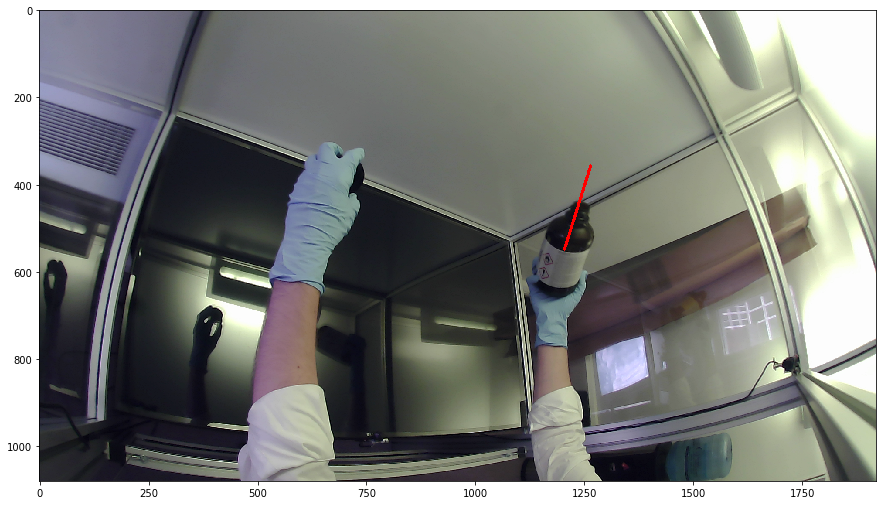

In [99]:
imo = [imo for imo in dataset['images'] if imo['id'] == 1][0]
anns = [ao for ao in dataset['annotations'] if ao['image_id'] == imo['id']][0]

from skimage import io
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def bbcc_from_xxww(boxes):
    cc = np.zeros( 2)
    cc[0] = boxes[0] + boxes[2] / 2
    cc[1] = boxes[1] + boxes[3] / 2
    
    return cc

bbcc = [int(i) for i in bbcc_from_xxww(np.array(anns['bbox']))]
print(bbcc)

angle = np.arctan(np.sin(anns['angle']) / np.cos(anns['angle']))
print(angle)
im = io.imread(imo['coco_url'])
print(np.sin(angle), np.cos(angle))
dvlx, dvly = bbcc[0] + np.cos(angle) * 200, bbcc[1] - np.sin(angle) * 200
print(dvlx, dvly)
cv2.line(im, (bbcc[0], bbcc[1]), (int(dvlx), int(dvly)), (255,0,0), 5)
plt.figure(figsize=(15,15))
plt.imshow(im)

In [101]:
np.arctan(np.sin(-np.pi/4) / np.cos(-np.pi/4)) * 180 / np.pi

-45.0

In [48]:
p = '/home/blanca/recordings/'
folders = ['Images0', 'Images1', 'Images2']
[os.makedirs(p + f, exist_ok=True) for f in folders]

[None, None, None]

In [54]:
for f in folders:
    out_p = p + f
    file = p + f[-1]+'.mp4'
    vidcap = cv2.VideoCapture(file)
    success, image = vidcap.read()
    count = 0
    while success:
        count += 1
        width = 10
        im_name = str(count).zfill(width) + '.jpg'
        cv2.imwrite(out_p + '/' + im_name, image)     # save frame as JPEG file      
        success, image = vidcap.read()
        print('Wrote a new frame as: ', out_p + '/' + im_name)
# 449, 449, 450

Wrote a new frame as:  /home/blanca/recordings/Images0/0000000001.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000002.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000003.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000004.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000005.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000006.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000007.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000008.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000009.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000010.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000011.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000012.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000013.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000014.jpg
Wrote a new frame as

#### cheching model output

(1080, 1920, 3)


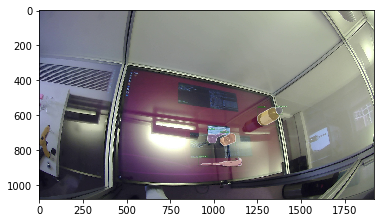

In [14]:
model_path = '/home/blanca/mnt/projects/vectors/classifier/classifier/checkpoint.pth.tar'
model = define_net(conf_file, input_nc, output_nc, ngf, model='encoder', norm='batch', n_classes=label_size,
                               n_downsample_global=n_downsample_global, padding_type=padding_type)
model.load_state(model_path)



## Create Video

In [87]:
import cv2
import os
import numpy as np

suffix = '2'

input_dir = '/home/blanca/mnt/projects/maskrcnn/mask-rcnn.pytorch/Outputs/test_toy_plane/'
output_dir = '/home/blanca/mnt/projects/maskrcnn/mask-rcnn.pytorch/Outputs/'
output_name = output_dir + 'test_toy_plane.avi'

images = sorted([img for img in np.sort(os.listdir(input_dir)) if img.endswith(".png")])

frame = cv2.imread(os.path.join(input_dir, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(output_name, fourcc, 15.0, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(input_dir, image)))

cv2.destroyAllWindows()
video.release()

In [8]:
import cv2
import os
import numpy as np

input_dir = '/home/blanca/mnt/projects/detector/mask-rcnn-multn.pytorch/Outputs/test_toy_plane'
output_dir = '/home/blanca/mnt/projects/detector/mask-rcnn-multn.pytorch/Outputs/'
output_name = output_dir + 'test_toy_plane.avi'

images = sorted([img for img in np.sort(os.listdir(input_dir)) if img.endswith(".png")])

frame = cv2.imread(os.path.join(input_dir, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(output_name, fourcc, 10.0, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(input_dir, image)))

cv2.destroyAllWindows()
video.release()

#### colormap

In [55]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np


def colormap(rgb=False):
    color_list = np.array(
        [
            0.000, 0.447, 0.741,
            0.850, 0.325, 0.098,
            0.929, 0.694, 0.125,
            0.494, 0.184, 0.556,
            0.466, 0.674, 0.188,
            0.301, 0.745, 0.933,
            0.635, 0.078, 0.184,
            0.300, 0.300, 0.300,
            0.600, 0.600, 0.600,
            1.000, 0.000, 0.000,
            1.000, 0.500, 0.000,
            0.749, 0.749, 0.000,
            0.000, 1.000, 0.000,
            0.000, 0.000, 1.000,
            0.667, 0.000, 1.000,
            0.333, 0.333, 0.000,
            0.333, 0.667, 0.000,
            0.333, 1.000, 0.000,
            0.667, 0.333, 0.000,
            0.667, 0.667, 0.000,
            0.667, 1.000, 0.000,
            1.000, 0.333, 0.000,
            1.000, 0.667, 0.000,
            1.000, 1.000, 0.000,
            0.000, 0.333, 0.500,
            0.000, 0.667, 0.500,
            0.000, 1.000, 0.500,
            0.333, 0.000, 0.500,
            0.333, 0.333, 0.500,
            0.333, 0.667, 0.500,
            0.333, 1.000, 0.500,
            0.667, 0.000, 0.500,
            0.667, 0.333, 0.500,
            0.667, 0.667, 0.500,
            0.667, 1.000, 0.500,
            1.000, 0.000, 0.500,
            1.000, 0.333, 0.500,
            1.000, 0.667, 0.500,
            1.000, 1.000, 0.500,
            0.000, 0.333, 1.000,
            0.000, 0.667, 1.000,
            0.000, 1.000, 1.000,
            0.333, 0.000, 1.000,
            0.333, 0.333, 1.000,
            0.333, 0.667, 1.000,
            0.333, 1.000, 1.000,
            0.667, 0.000, 1.000,
            0.667, 0.333, 1.000,
            0.667, 0.667, 1.000,
            0.667, 1.000, 1.000,
            1.000, 0.000, 1.000,
            1.000, 0.333, 1.000,
            1.000, 0.667, 1.000,
            0.167, 0.000, 0.000,
            0.333, 0.000, 0.000,
            0.500, 0.000, 0.000,
            0.667, 0.000, 0.000,
            0.833, 0.000, 0.000,
            1.000, 0.000, 0.000,
            0.000, 0.167, 0.000,
            0.000, 0.333, 0.000,
            0.000, 0.500, 0.000,
            0.000, 0.667, 0.000,
            0.000, 0.833, 0.000,
            0.000, 1.000, 0.000,
            0.000, 0.000, 0.167,
            0.000, 0.000, 0.333,
            0.000, 0.000, 0.500,
            0.000, 0.000, 0.667,
            0.000, 0.000, 0.833,
            0.000, 0.000, 1.000,
            0.000, 0.000, 0.000,
            0.143, 0.143, 0.143,
            0.286, 0.286, 0.286,
            0.429, 0.429, 0.429,
            0.571, 0.571, 0.571,
            0.714, 0.714, 0.714,
            0.857, 0.857, 0.857,
            1.000, 1.000, 1.000
        ]
    ).astype(np.float32)
    color_list = color_list.reshape((-1, 3)) * 255
    if not rgb:
        color_list = color_list[:, ::-1]
    return color_list

In [56]:
color_list = colormap(rgb=True) / 255


In [58]:
mask_color_id = 0
for i in range (20):
    color_mask = color_list[mask_color_id % len(color_list), 0:3]
    mask_color_id += 1
    print(color_mask)

[0.    0.447 0.741]
[0.85  0.325 0.098]
[0.929 0.694 0.125]
[0.494 0.184 0.556]
[0.466 0.674 0.188]
[0.301 0.745 0.933]
[0.635 0.078 0.184]
[0.3 0.3 0.3]
[0.6 0.6 0.6]
[1. 0. 0.]
[1.  0.5 0. ]
[0.749 0.749 0.   ]
[0. 1. 0.]
[0. 0. 1.]
[0.667 0.    1.   ]
[0.333 0.333 0.   ]
[0.333 0.667 0.   ]
[0.333 1.    0.   ]
[0.667 0.333 0.   ]
[0.667 0.667 0.   ]


In [60]:
classes = cat_dic
classes

{0: 'beaker',
 1: 'bottle',
 2: 'flask',
 3: 'bare_hand',
 4: 'glove_hand',
 5: 'pipette',
 6: 'pipette_label',
 7: 'bottle_cap'}

In [62]:
color_dict = {
    '__background__': [0.   , 0.447, 0.741],
    'beaker':         [0.85 , 0.325, 0.098],
    'bottle':         [0.929, 0.694, 0.125],
    'flask':          [0.494, 0.184, 0.556],
    'bare_hand':      [0.466, 0.674, 0.188],
    'glove_hand':     [0.301, 0.745, 0.933],
    'pipette':        [0.635, 0.078, 0.184],
    'pipette_label':  [0.3  , 0.3  , 0.3  ],
    'bottle_cap':     [0.6  , 0.6  , 0.6  ],
}

In [65]:
mask_color_id = 0
for i in range (9):
    color_mask = color_list[mask_color_id % len(color_list), 0:3]
    mask_color_id += 1
    color_mask_fixed = color_dict[i]
    print(color_mask, color_mask_fixed)

[0.    0.447 0.741] [0.0, 0.447, 0.741]
[0.85  0.325 0.098] [0.85, 0.325, 0.098]
[0.929 0.694 0.125] [0.929, 0.694, 0.125]
[0.494 0.184 0.556] [0.494, 0.184, 0.556]
[0.466 0.674 0.188] [0.466, 0.674, 0.188]
[0.301 0.745 0.933] [0.301, 0.745, 0.933]
[0.635 0.078 0.184] [0.635, 0.078, 0.184]
[0.3 0.3 0.3] [0.3, 0.3, 0.3]
[0.6 0.6 0.6] [0.6, 0.6, 0.6]


In [11]:
# pytorch model 
import cv2
import os
import numpy as np

suffix = '2'

input_dir = '/home/blanca/mnt/projects/detector/mask-rcnn.pytorch/output/R-101/tmp/r%s' %suffix 
output_dir = '/home/blanca/mnt/projects/detector/R-101-mask-output/tmp/'
output_name = output_dir + 'torch_r%s.avi' %suffix

images = sorted([img for img in np.sort(os.listdir(input_dir)) if img.endswith(".png")])

frame = cv2.imread(os.path.join(input_dir, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(output_name, fourcc, 10.0, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(input_dir, image)))

cv2.destroyAllWindows()
video.release()

#### Download images from annotations path